# Exploratory Data Analysis

----

### Import Libraries

In [1]:
# Basic
import numpy as np
import pandas as pd

# Timeseries
from statsmodels.api import tsa
import statsmodels.api as sm

# Visualization
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

# Custom Helper Functions
import sys
sys.path.append('../libraries')
import cleaning_helper_functions as prep

----

### Read Data

In [2]:
df_earth_vitals = pd.read_csv('../data/cleaned/earth_vitals.csv',index_col=0)
df_earth_vitals.index = pd.to_datetime(df_earth_vitals.index)

<table>
  <tr>
    <th style="text-align: left; background: lightgrey">Column Name</th>
    <th style="text-align: left; background: lightgrey">Column Contents</th>
    <th style="text-align: left; background: lightgrey">Source</th>
  </tr>
  <tr>
    <td style="text-align: left"> <code>global_sea_ice_extent</code> </td>
    <td style="text-align: left">Global sea ice extent measured in sq km (10^6).</td>
    <td style="text-align: left"><a href="https://nsidc.org/data/seaice_index">NSIDC</a></td>
  </tr>
  <tr>
    <td style="text-align: left"><code>sea_temp_anomaly</code></td>
    <td style="text-align: left">Global sea surface temperature anomaly relative to 1991-2020 average.</td>
    <td style="text-align: left"><a href="https://www.metoffice.gov.uk/hadobs/hadsst4/">Met Office Hadley Centre</a></td>
  </tr>
  <tr>
    <td style="text-align: left"><code>total_ice_sheet_mass_change</code></td>
    <td style="text-align: left">Combined change in ice mass of the Greeland and Antarctic Ice Sheets since April 2002 (Gigatonnes)</td>
    <td style="text-align: left"><a href="https://climate.nasa.gov/vital-signs/ice-sheets/">NASA</a></td>
  </tr>
  <tr>
    <tr>
    <td style="text-align: left"><code>global_mean_sea_level</code></td>
    <td style="text-align: left">Change in sea level relative to April 2002 (mm)</td>
    <td style="text-align: left"><a href="https://climate.nasa.gov/vital-signs/sea-level/">NASA Goddard Space Flight Center</a></td>
  </tr>
</table>


----

### Check Data

In [3]:
prep.basic_eda(df_earth_vitals)

SHAPE
Rows: 248 	 Columns: 4

DATATYPES
Columns: 
global_sea_ice_extent          float64
sea_temp_anomaly               float64
total_ice_sheet_mass_change    float64
global_mean_sea_level          float64
dtype: object
Index: datetime64

UNIQUE VALUES
global_sea_ice_extent          248
sea_temp_anomaly               247
total_ice_sheet_mass_change    248
global_mean_sea_level          246
dtype: int64

NULL VALUES
Total null rows: 0
Percentage null rows: 0.0%

DUPLICATES
Total duplicate rows: 0
Percentage duplicate rows: 0.0%

-----



In [4]:
df_earth_vitals.head()

,global_sea_ice_extent,sea_temp_anomaly,total_ice_sheet_mass_change,global_mean_sea_level
2002-04-30,20.627267,0.45826,27.303182,0.00
2002-05-31,22.482161,0.46104,49.320792,-1.34
2002-06-30,23.959167,0.46607,-56.745000,-1.69
2002-07-31,24.688871,0.41203,-169.678182,3.42
2002-08-31,23.665677,0.43217,-257.390352,8.99


----

### Overall Distribution, Trend and Seasonality

In [5]:
# Loop through each column in the dataframe.
for x in df_earth_vitals.columns:

    # Break down the current column in to its trend, seasonal and residual components.
    decomposition = tsa.seasonal_decompose(df_earth_vitals[x], model='addative')

    # Create dataframe containing the observed distribution and individual components of the current column.
    df_decomp = pd.DataFrame()
    df_decomp['Observed'] = df_earth_vitals[x]
    df_decomp["Trend"] = decomposition.trend
    df_decomp["Seasonal"] = decomposition.seasonal
    df_decomp["Residual"] = decomposition.resid

    # Create a list of the required subplot titles.
    cols = ["Observed","Trend", "Seasonal", "Residual"]

    # Create a new subplot for each column in the df_earth_vitals dataframe.
    fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

    # Loop through each componenet the current column to plot in each subplot.
    for i, col in enumerate(cols):
        fig.add_trace(
            go.Scatter(x=df_decomp.index, y=df_decomp[col]),
            row=i+1,
            col=1
        )
    fig.update_layout(height=800, width=1200, showlegend=False,title=x.upper())
    fig.show()

Looking at the observed distribution of all the variables, the seasonality seems to remain fairly consistent across all of them, so i have used an addative model when breaking down the variables in to their component parts.

`global_sea_ice_extent` - even with the data for the northern and southern hemispheres combined, the data still shows a strong seasonal pattern, with ice at its greatest extent in November and at its lowest levels in February. This suggests a greater amount of overall sea ice is present in the Northern hemisphere. The overall trend is less pronounced than the other variables, but still shows an overall decreasing trend in the amount of sea ice globally. It looks like there was a particularly large decrease between 2015 and 2018. While there is quite a lot of residual noise in the data, the amount of noise appears to be decreasing as time goes on, with the maximum fluctuations decreasing the closer to present day. This could be due to the overall decrease in ice meaning the percentage fluctuation actually remains at a similar level.

`sea_temp_anomaly` - again, there is a strong seasonal pattern here, with the highest anomalies observed in August, and the most negative anomalies in December, lining up with the northern hemisphere summer/winter. The trend for sea temperature anomalies is clearly increasing YOY, albeit with a couple of uncharacteristic peaks in 2010 and 2016. However, there is also a lot of noise present in the data, with fluctuations between 0.1 and -0.1 degrees.

`total_ice_sheet_mass_change` - this variable is perhaps the easiest to examine, showing a very clear, very consistent downward trend with very little seasonality or noise. This is perhaps the most concerning pattern as, unlike with sea ice, the sheet ice that is lost each year isn't reforming.

`global_mean_sea_level` - again, this variable shows a very clear, consistent upward trend. It this also shows strong seasonality. However, that seasonality doesn't seem to line up with any of the independent variables i'm currently considering. I'll be performing a more in depth analysis of sea level going forwards to see which variables contribute the most to sea level. 

----

### Multicollinearity

I'll need to check to see whether any of the independent variables are correlated with each other. If they are, then one of those variables is unlikely to contribute anything to any models i look to implement going forwards.

In [6]:
# Remove the dependent variable
X = df_earth_vitals.drop('global_mean_sea_level',axis=1)

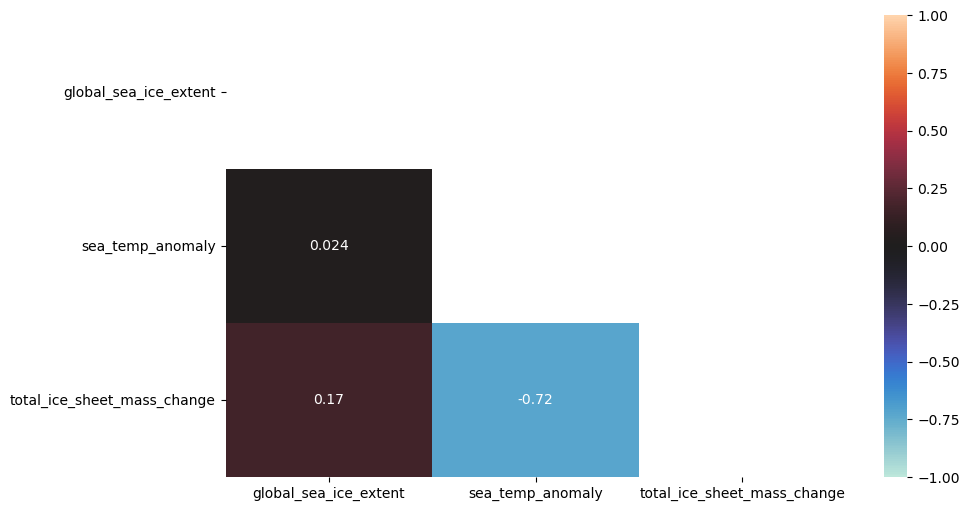

In [7]:
# Plot heatmap to check the coefficients of each variable combination.
plt.figure(figsize=(10, 6))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap="icefire", annot=True,mask=matrix)
plt.show()

`sea_temp_anomaly` and `total_ice_sheet_mass_loss` seem to have quite a strong negative correlation with each other. This is probably to be expected, as ice sheet mass loss is closely linked to global warming, which is also the main cause of increased sea temperature anomalies.

I find it surprising to see that `sea_temp_anomaly` shows incredibly weak multicollinearity with `global_sea_ice_extent`. I would have expected to see a negative correlation of some kind, as logic would suggest that as sea temperature increases, sea ice extent would decrease.

Likewise, i find it surprising that there is so little correlation between `total_ice_sheet_mass_change` and `global_sea_ice_extent`, suggesting that the variation in their distribution are caused by different factors.

----

### Causality

While my initial models will look at making a predictive model based solely on the pattern of GMSL, i will later on look to introduce the independent variables as exogenous variables. For these to contribute to the model they will need to show some pattern of causality with the dependent variable. I'll conduct a Granger Causality Test on each of my variable pairings to see how useful each one will be.

In [8]:
for col in df_earth_vitals.columns[:3]:
    print(col)
    print(grangercausalitytests(df_earth_vitals[['global_mean_sea_level',col]],maxlag=2))
    print()

global_sea_ice_extent

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2283  , p=0.0077  , df_denom=244, df_num=1
ssr based chi2 test:   chi2=7.3172  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2109  , p=0.0072  , df=1
parameter F test:         F=7.2283  , p=0.0077  , df_denom=244, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9632  , p=0.3831  , df_denom=241, df_num=2
ssr based chi2 test:   chi2=1.9664  , p=0.3741  , df=2
likelihood ratio test: chi2=1.9586  , p=0.3756  , df=2
parameter F test:         F=0.9632  , p=0.3831  , df_denom=241, df_num=2
{1: ({'ssr_ftest': (7.228337761093492, 0.0076706760870950816, 244.0, 1), 'ssr_chi2test': (7.317210766352839, 0.006829732929202344, 1), 'lrtest': (7.21092108671337, 0.007246129827581801, 1), 'params_ftest': (7.22833776109326, 0.007670676087095975, 244.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000019BA969F460>, <statsmodels.regres

`sea_temp_anomaly` and `total_ice_sheet_mass_change` both show p-values close to 0, meaning that there is at least some causality between each variable and the target variable. However, while `global_sea_ice_extent` shows low p-values at one lag, those p-values get much higher at two lags and beyond. This would suggest that there is very little causality between sea ice extent and global mean sea level. This does line up with the understanding that because the formation of sea ice doesn't actually remove any volume of water from the sea, it doesn't have any bearing on the sea level. As a result, i will drop this column from my data at the beginning of the modelling stage of the project.

----